# NER Recognition Fine Tuning DistilBERT - Restaurant Search Project
* Notebook by Adam Lang
* Date: 12/11/2024

# Overview
* In this notebook I will demonstrate how to implement Named Entity Recognition (NER) by fine tuning DistilBERT transformer model.
* The subject/project is for "Restaurant Search" application.

# Named Entity Recognition (NER) - Quick Review
* **NER Modeling is also most commonly known as Token Classifiation!!**
* As you may or may not know, NER is a powerful technique that is often used to identify and classify "named entities" such as but not limited to:
  * people
  * places
  * organizations
  * dates
  * locations
  * ...etc...

# Tokens and Tags in NER Models
* NER modeling breaks data down into tokens and tags for a model to process and classify the information.
* The acronym for the schema often used is known as `BILUO` which stands for:
  * Begin
  * In
  * Last
  * Unit
  * Out
* A full breakdown of this schema as demonstrated by the spacy library:
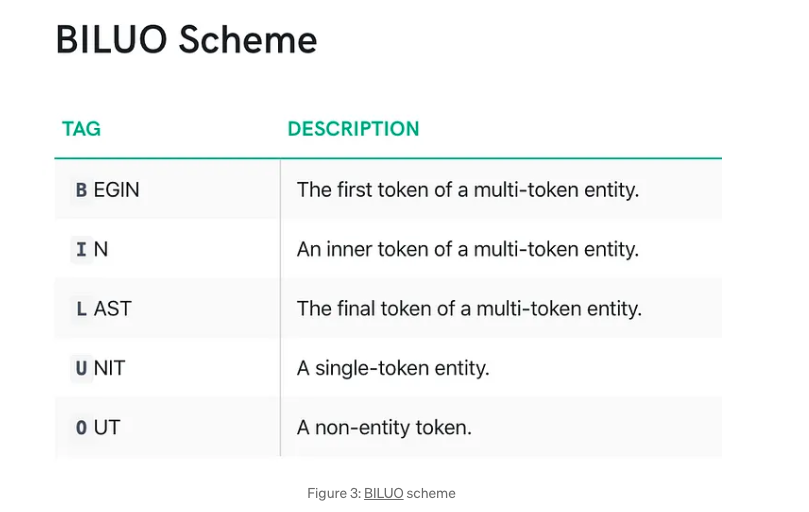


* However, a famous paper by Ratinov and Roth entitled "Design Challenges and Misconceptions in Named Entity Recognition"
showedthat BILOU encoding scheme significantly outperforms BIO or IOB encoding as both are more difficult for a model to learn from data.
  * The main reason is the BILOU schema has boundary tokens making it easier for a NER model to train on.
  * Link to paper: https://aclanthology.org/W09-1119/
  * Another good NER resource: https://towardsdatascience.com/extend-named-entity-recogniser-ner-to-label-new-entities-with-spacy-339ee5979044
  * Another good resource: https://medium.com/@muskaan.maurya06/name-entity-recognition-and-various-tagging-schemes-533f2ac99f52


* Example of the IOB or BIO schema:
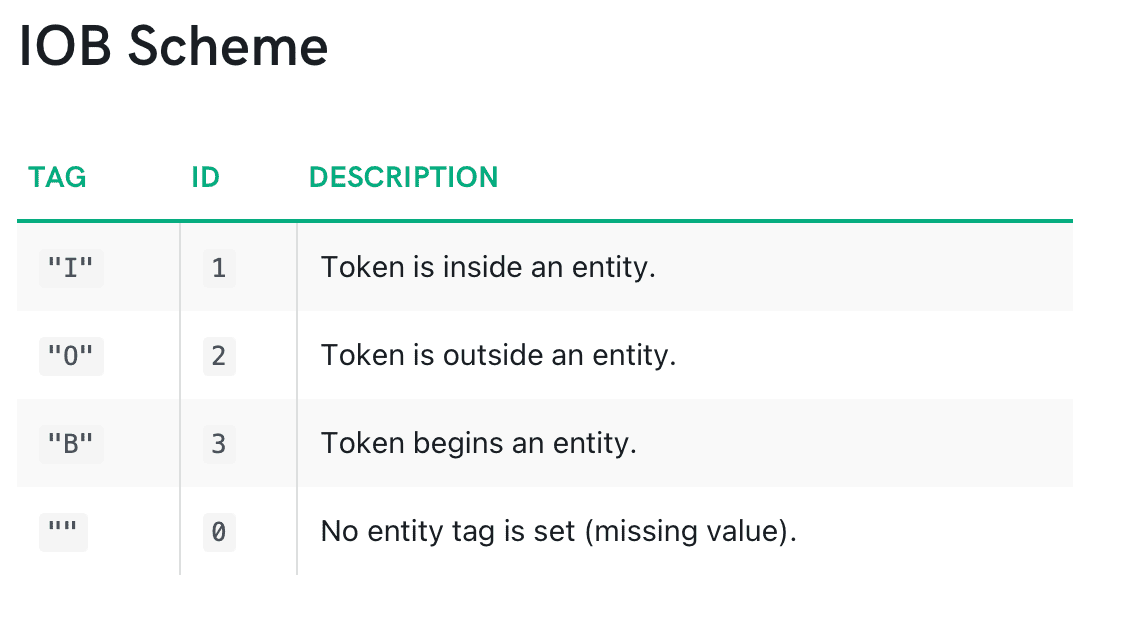

## Spacy `displaCy Entity Visualization`
* This is a good demo that spacy put together to test out NER modeling: https://demos.explosion.ai/displacy-ent

## Other NER Schemas
* There are 7 "standard" NER schemas:
There are 7 known tagging schemes:
1. IO
2. IBO/BIO
3. IOE
4. IOBES/BIOES
5. BI
6. IE
7. BIES
* This is an excellent breakdown application of these 7 schemas, source: Borelli et al. 2024.
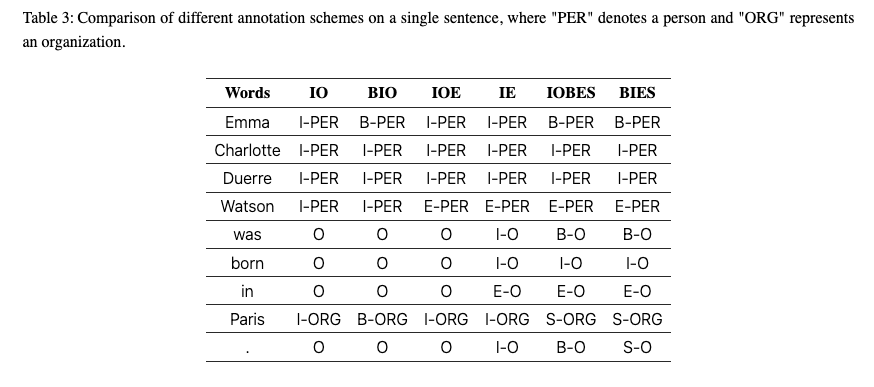

* Full paper: https://arxiv.org/html/2401.10825v1/#S7.T3

## Modeling Approaches to NER
* This is an excellent review chart of the various NER modeling approaches which again comes from the above paper by Borelli et al. 2024
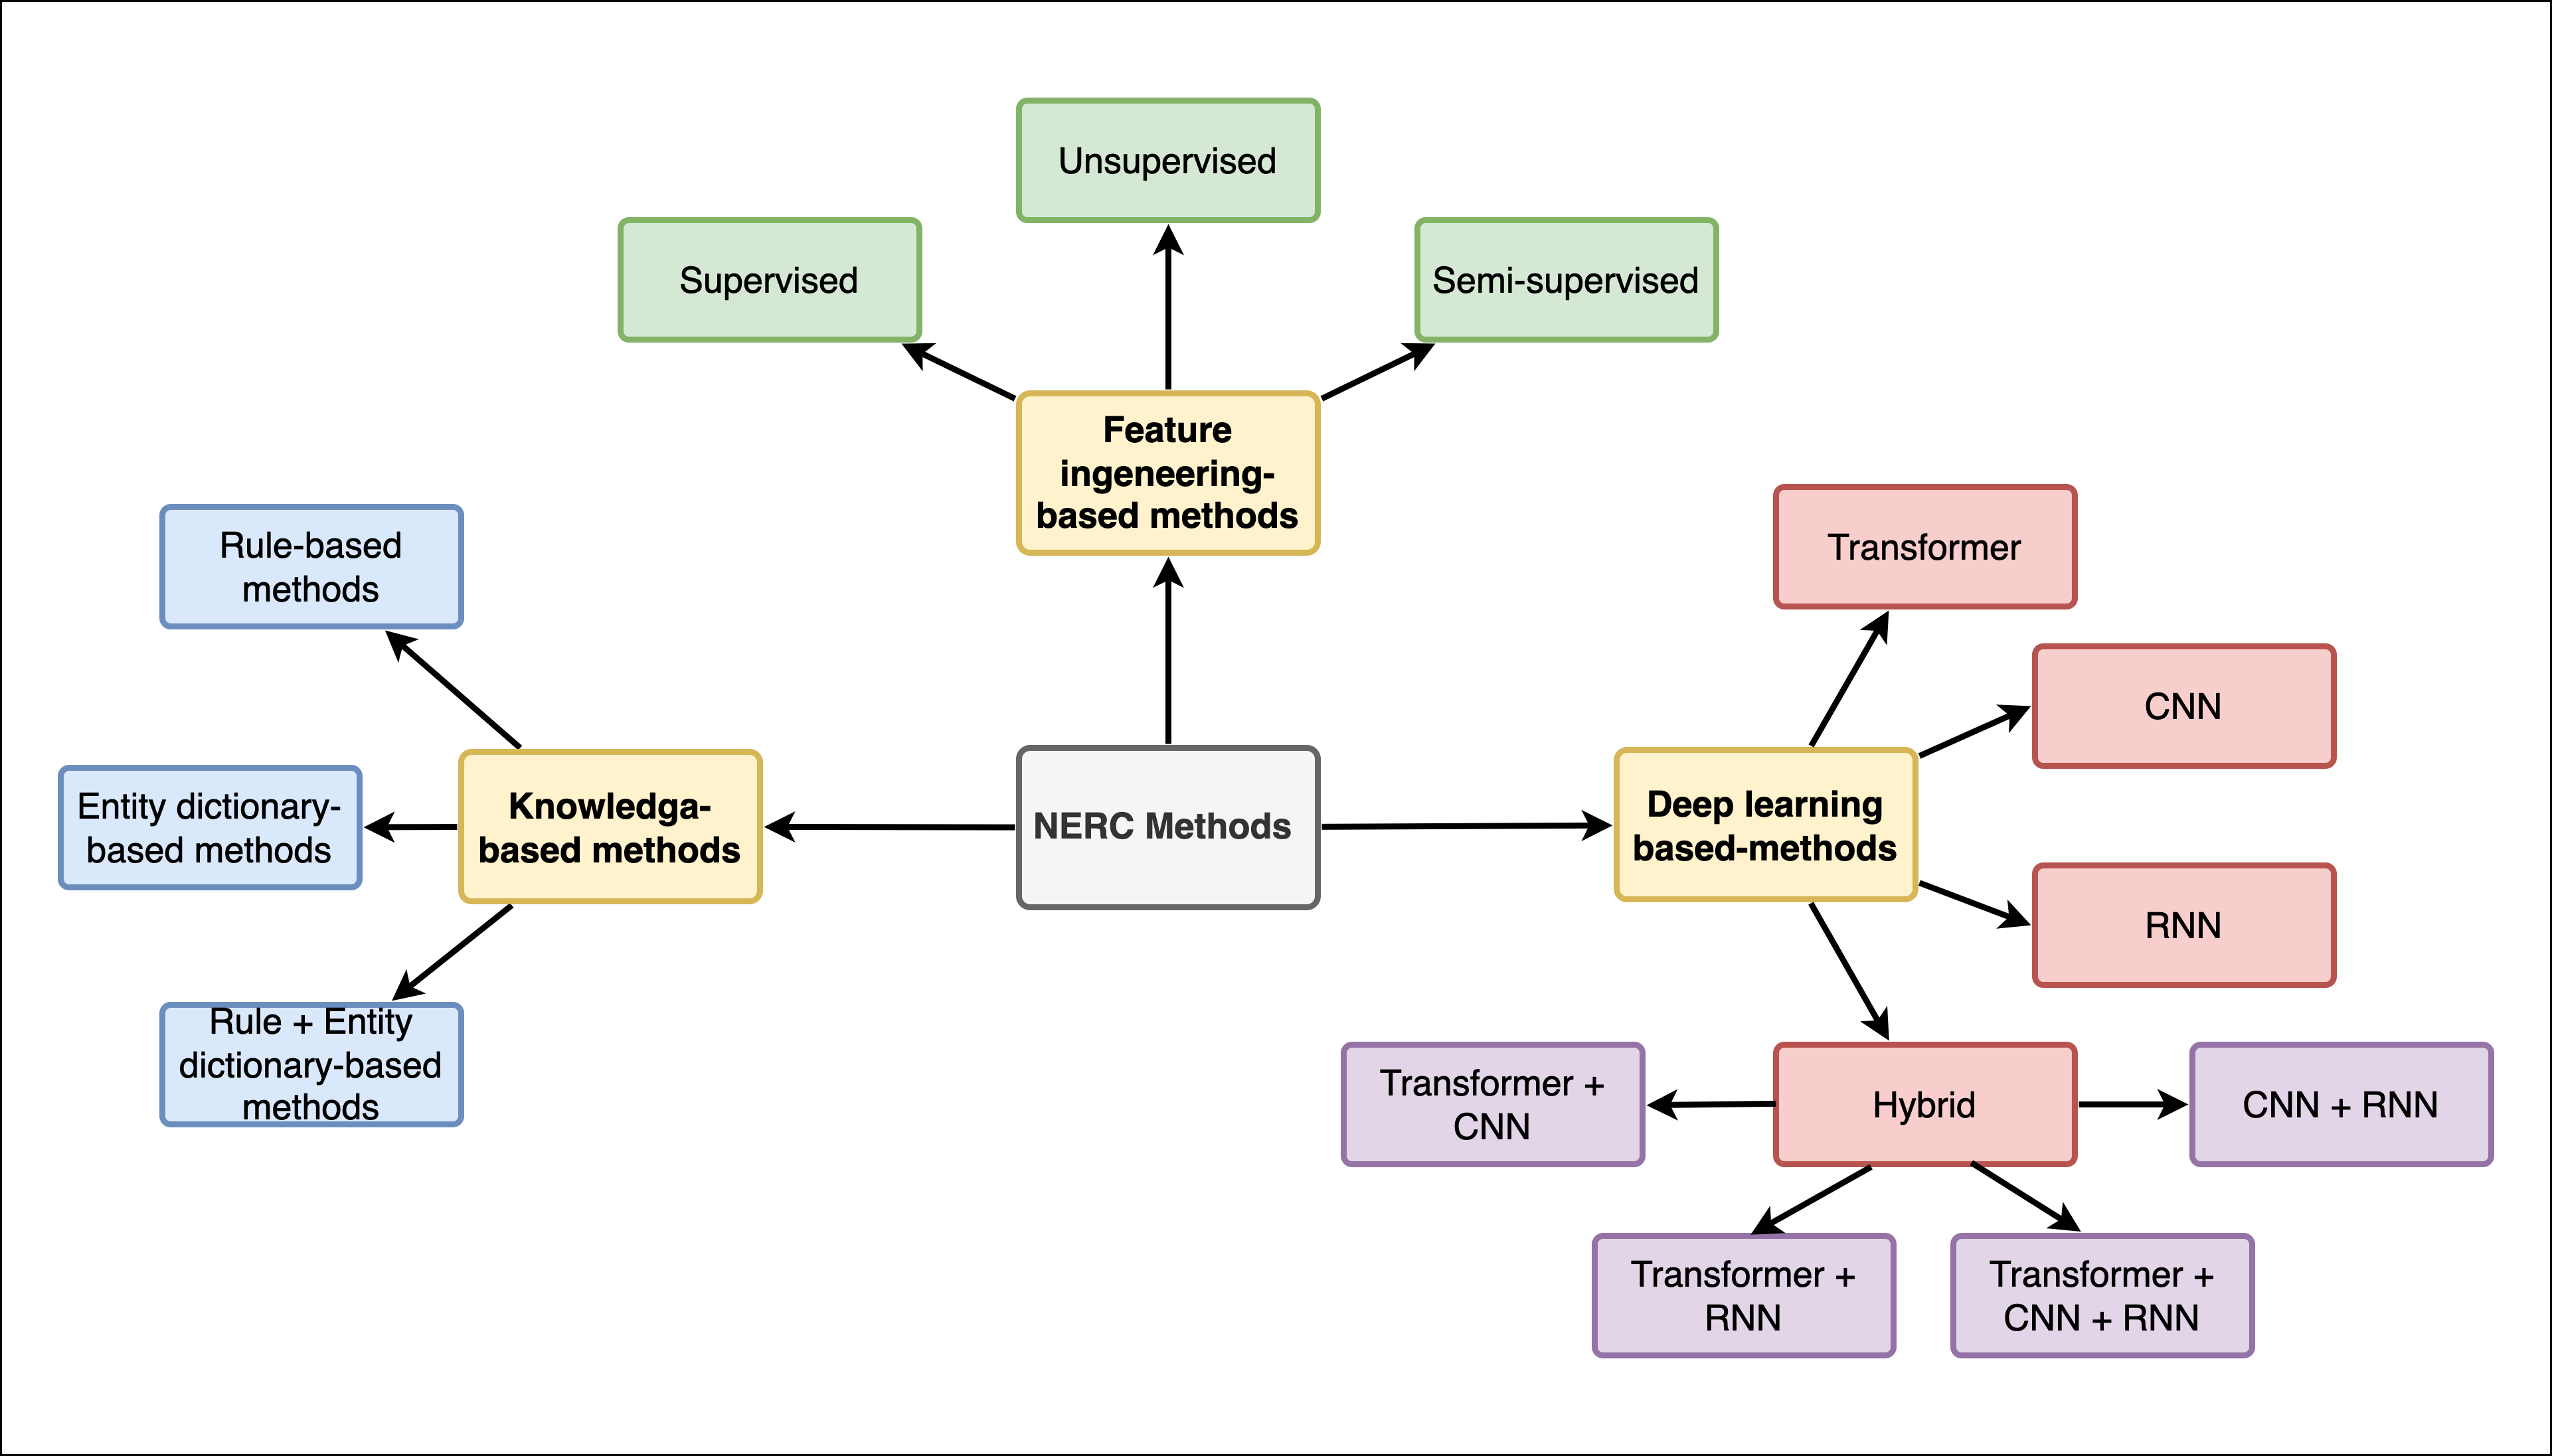

# General NER Modeling Workflow
1. Text input
  * NER begins with text which can be word, sentence, paragraph, document or larger corpora.

2. Tokenization
  * Input text is split into individual words or tokens (tokenization).
  * Tokenization is MOST important in NER models because it works on a token by token level.

3. Entity Recognition
  * Tokenized text is analyzed to identify "spans" of tokens that correspond to named entities.
  * NER systems use various techniques such as:
    * rule-based approaches
    * machine learning models
      * conditional random fields
      * deep learning
    * combination of methods

4. Entity/Token Classification
  * After entities are recognized they are then classified into predefined categories of choice such as:
    * person
    * organization
    * location
    * date
    * number
    * product
    * company
    * ...etc...
  * The purpose of these categories is to help organize and provide context to the recognized entities.

5. Output
   * Final output of NER model is structured representation of the original text with identified named entities and their respective categories.
   * The output can then be used for various purposes such as but not limited to:
      * information extraction
      * content summarization
      * sentiment analysis
      * etc...

# Architecture of NER Transformer Models
* This section is sourced from the excellent paper by Marcinczuk in June 2024 entitled: **Transformer-based Named Entity Recognition with Combined Data Representation**
  * arxiv link: https://arxiv.org/html/2406.17474v1
* The original architecture described by Devlin et al. in their 2019 paper used this method:
  * NER modeled as a sequence classification task.
  * The neural network architecture consists of two main elements:
    * 1) Pre-trained language model (PLM) embeddings
    * 2) Classifier layer
* The PLM part generates a context-based representation of each word (a vector of the first words subtoken).
* The classifier layer outputs one of the IOB2 labels for each word.
  * The label set depends on a given datasets categories of named entities.
  * In post-processing, the sequences of IOB2 labels are wrapped into continuous annotations.
  * The text is divided into tokens, and then each token is divided into subtokens by the model tokenizer.
  * Some tokes are divided into more than one subtoken.
  * For example below, the Eiffel word is tokenized into three subtokens:
    * E
    * iff
    * el
      * In such a case, **only the first subtoken** is passed through the classifier to obtain the label of the word.
      * This approach is sufficient due to the attention mechanism of transform-based models.
* Representation of this architecture from the paper noted above:

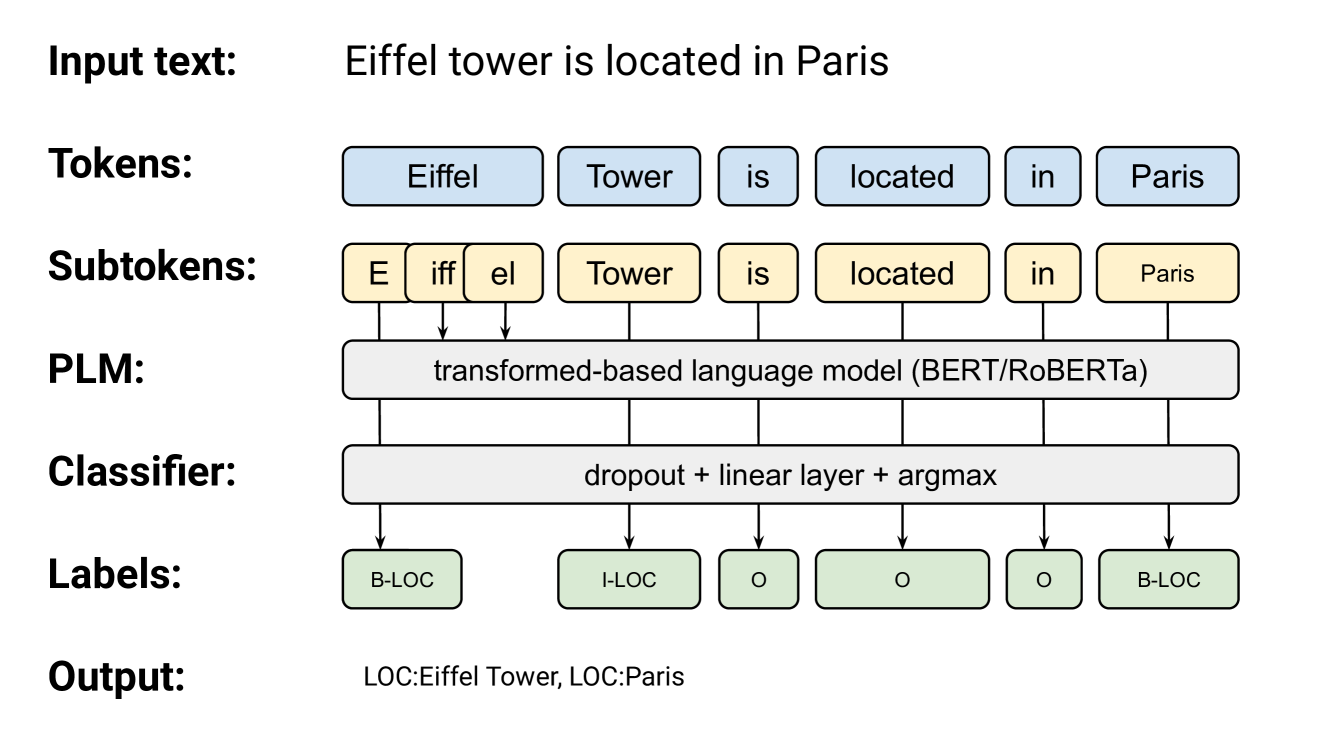


# Dataset
* For this project there is an open source dataset available via the huggingface hub called the **MIT Restaurant Dataset**
  * dataset card: https://huggingface.co/datasets/tner/mit_restaurant
* Note: This dataset is part of the TNER project which can be found here: https://github.com/asahi417/tner
  * T-NER is a Python tool for language model finetuning on named-entity-recognition (NER) implemented in pytorch,

* The `label2id` dictionary from huggingface looks like this:
```
{
    "O": 0,
    "B-Rating": 1,
    "I-Rating": 2,
    "B-Amenity": 3,
    "I-Amenity": 4,
    "B-Location": 5,
    "I-Location": 6,
    "B-Restaurant_Name": 7,
    "I-Restaurant_Name": 8,
    "B-Price": 9,
    "B-Hours": 10,
    "I-Hours": 11,
    "B-Dish": 12,
    "I-Dish": 13,
    "B-Cuisine": 14,
    "I-Price": 15,
    "I-Cuisine": 16
}
```

# Load Dataset

In [1]:
## hide warnings
import warnings
warnings.filterwarnings('ignore')

## Install Dependencies

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets

In [3]:
## other imports
import pandas as pd
import numpy as np
import json
import requests

In [4]:
## train data
train_data = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/mit_restaurant_search_ner/train.bio",
                         sep="\t", #seperate tabs in data
                         header=None)
train_data.head()

,0,1
0,B-Rating,2
1,I-Rating,start
2,O,restaurants
3,O,with
4,B-Amenity,inside


Above we can see the Tags in the first column and the tokens in the 2nd column.

In [5]:
## another way is to read this as a generic text file
response = requests.get("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/mit_restaurant_search_ner/train.bio")
response = response.text

In [6]:
# parse response data
response.splitlines()

['B-Rating\t2',
 'I-Rating\tstart',
 'O\trestaurants',
 'O\twith',
 'B-Amenity\tinside',
 'I-Amenity\tdining',
 '',
 'O\t34',
 '',
 'B-Rating\t5',
 'I-Rating\tstar',
 'O\tresturants',
 'B-Location\tin',
 'I-Location\tmy',
 'I-Location\ttown',
 '',
 'O\t98',
 'B-Restaurant_Name\thong',
 'I-Restaurant_Name\tkong',
 'O\trestaurant',
 'B-Price\treasonable',
 'O\tprices',
 '',
 'O\ta',
 'O\tgreat',
 'O\tlunch',
 'O\tspot',
 'O\tbut',
 'B-Hours\topen',
 'I-Hours\ttill',
 'I-Hours\t2',
 'I-Hours\ta',
 'I-Hours\tm',
 'B-Restaurant_Name\tpassims',
 'I-Restaurant_Name\tkitchen',
 '',
 'O\ta',
 'O\tplace',
 'O\tthat',
 'O\tserves',
 'B-Dish\tsoft',
 'I-Dish\tserve',
 'I-Dish\tice',
 'I-Dish\tcream',
 '',
 'O\ta',
 'O\trestaurant',
 'O\tthat',
 'O\tis',
 'B-Rating\tgood',
 'B-Amenity\tfor',
 'I-Amenity\tgroups',
 '',
 'O\ta',
 'B-Dish\tsalad',
 'O\twould',
 'O\tmake',
 'O\tmy',
 'O\tday',
 '',
 'O\ta',
 'B-Cuisine\tsmoothie',
 'O\twould',
 'O\thit',
 'O\tthe',
 'O\tspot',
 '',
 'O\ta',
 'B-Dish\ts

# Dataset Preparation
* We could have loaded the dataset in the proper format direct from hugging face, but instead we loaded it in this tagged format to demo how to prepare the data loader for NER modeling.

## Train Data prep
* Prepare tags and tokens

In [7]:
## empty list for train tokens and tags
train_tokens = []
train_tags = []

# empty list for temp tokens and tags
temp_tokens = []
temp_tags = []
# loop through and append tags and tokens
for line in response.splitlines():
  if line.strip(): # check if the line is not empty after stripping whitespace
    try:
      tag, token = line.strip().split("\t")
      temp_tags.append(tag)
      temp_tokens.append(token)
    except ValueError:
      print(f"Skipping line: {line.strip()} - Could not split into tag and token") #handle lines that can't be split
  else:
    train_tokens.append(temp_tokens)
    train_tags.append(temp_tags)

    temp_tokens, temp_tags = [], []

In [8]:
# len of train_tokens, train_tags
print(f"Len of train tokens: {len(train_tokens)}")
print(f"Len of train tags: {len(train_tags)}")

Len of train tokens: 7659
Len of train tags: 7659


## Test Data prep
* Prepare test tags and tokens.
* Similar to above, we have to parse the test dataset and extract the tokens and tags.

In [9]:
## another way is to read this as a generic text file
response = requests.get("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/mit_restaurant_search_ner/test.bio")
response = response.text
lines = response.splitlines()

## empty list for train tokens and tags
test_tokens = []
test_tags = []

# empty list for temp tokens and tags
temp_tokens = []
temp_tags = []
# loop through and append tags and tokens
for line in lines: #iterate through lines list
  if line.strip(): # check if the line is not empty after stripping whitespace
    try:
      tag, token = line.strip().split("\t")
      temp_tags.append(tag)
      temp_tokens.append(token)
    except ValueError:
      print(f"Skipping line: {line.strip()} - Could not split into tag and token") #handle lines that can't be split
  else:
    test_tokens.append(temp_tokens)
    test_tags.append(temp_tags)

    temp_tokens, temp_tags = [], []



## len of test tokens and tags
print(f"Len test tokens: {len(test_tokens)}")
print(f"Len test tags: {len(test_tags)} ")

Len test tokens: 1520
Len test tags: 1520 


# Hugging Face Dataset/DataLoader
* Now we need to create a hugging face dataset to load the data into the model this makes it easier for the model to process the data.

In [10]:
from datasets import Dataset, DatasetDict

## create pandas df_train to load into huggingface format
df_train = pd.DataFrame({'tokens': train_tokens,
                  'ner_tags_str': train_tags})
## Train split
train = Dataset.from_pandas(df_train)


## create pandas df_test to load into huggingface format
df_test = pd.DataFrame({'tokens': test_tokens,
                  'ner_tags_str': test_tags})
## Train split
train = Dataset.from_pandas(df_train)
test = Dataset.from_pandas(df_test)



## create train set
dataset = DatasetDict({'train': train,
                       'test': test,
                       'validation': test}) #use validation as test dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags_str'],
        num_rows: 7659
    })
    test: Dataset({
        features: ['tokens', 'ner_tags_str'],
        num_rows: 1520
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags_str'],
        num_rows: 1520
    })
})

In [11]:
## view train index 0
dataset['train'][0]

{'tokens': ['2', 'start', 'restaurants', 'with', 'inside', 'dining'],
 'ner_tags_str': ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']}

Summary
* We need to define unique tag ids to the `ner_tags_str`

# Assign Tags to `ner_tags_str` - preprocessing
* This process is similar for a multiclass classification problem where we have to perform the step of `id2label` and `label2id` mapping.

In [12]:
## assign tags --> using set()
unique_tags = set()

## 1. loop through dataset
for tag in dataset['train']['ner_tags_str']:
  unique_tags.update(tag)

## 2. remove NER tags
unique_tags = list(set([x[2:] for x in list(unique_tags) if x != 'O']))
unique_tags

## 3. now we map tag2index
tag2index = {"O": 0}
for i, tag in enumerate(unique_tags):
  tag2index[f'B-{tag}'] = len(tag2index)
  tag2index[f'I-{tag}'] = len(tag2index)

# print(tag2index) -- if you want to checkpoint and see tag2index

## 4. now we map index2tag
index2tag = {v:k for k,v in tag2index.items()}

In [13]:
## now we have the tags and indexes
print(f"This is the tag2index: {tag2index}")
print()
print(f"This is the index2tag: {index2tag}")

This is the tag2index: {'O': 0, 'B-Rating': 1, 'I-Rating': 2, 'B-Amenity': 3, 'I-Amenity': 4, 'B-Location': 5, 'I-Location': 6, 'B-Cuisine': 7, 'I-Cuisine': 8, 'B-Restaurant_Name': 9, 'I-Restaurant_Name': 10, 'B-Hours': 11, 'I-Hours': 12, 'B-Dish': 13, 'I-Dish': 14, 'B-Price': 15, 'I-Price': 16}

This is the index2tag: {0: 'O', 1: 'B-Rating', 2: 'I-Rating', 3: 'B-Amenity', 4: 'I-Amenity', 5: 'B-Location', 6: 'I-Location', 7: 'B-Cuisine', 8: 'I-Cuisine', 9: 'B-Restaurant_Name', 10: 'I-Restaurant_Name', 11: 'B-Hours', 12: 'I-Hours', 13: 'B-Dish', 14: 'I-Dish', 15: 'B-Price', 16: 'I-Price'}


In [14]:
## now we need to map this to the dataset/dataloader
dataset = dataset.map(lambda example: {"ner_tags": [tag2index[tag] for tag in example['ner_tags_str']]})

Map:   0%|          | 0/7659 [00:00<?, ? examples/s]

Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

In [15]:
## now we need to map this to the dataset/dataloader
#dataset = dataset.map(lambda example: {"ner_tags": [tag2index[tag] for tag in example['ner_tags_str']]})['train'][0]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags_str', 'ner_tags'],
        num_rows: 7659
    })
    test: Dataset({
        features: ['tokens', 'ner_tags_str', 'ner_tags'],
        num_rows: 1520
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags_str', 'ner_tags'],
        num_rows: 1520
    })
})

# Model Building
* Model we are using: `distilbert-base-uncased`
  * model card: https://huggingface.co/distilbert/distilbert-base-uncased

In [17]:
from transformers import AutoTokenizer

# load model checkpoint
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
## lets look at the tokenizer
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [23]:
## lets test out the tokenizer
input = dataset['train'][0]['tokens']
output = tokenizer(input,
                   is_split_into_words=True)

In [24]:
input

['2', 'start', 'restaurants', 'with', 'inside', 'dining']

In [25]:
output

{'input_ids': [101, 1016, 2707, 7884, 2007, 2503, 7759, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [26]:
## word ids
output.word_ids()

[None, 0, 1, 2, 3, 4, 5, None]

# NER Labels Alignment with Tokens

In [33]:
## convert ids to tokens
input = dataset['train'][2]['tokens']
output = tokenizer(input, is_split_into_words=True)

# get token ids from output of tokenizer
token_ids = output.input_ids
tokenizer.convert_ids_to_tokens(token_ids)

['[CLS]', '5', 'star', 'rest', '##ura', '##nts', 'in', 'my', 'town', '[SEP]']

Summary
* The problem here is the subword tokenization that resulted from the word `restaurant` being split into 3 tokens.
* **We need to replace the outside token here to resolve this issue.**

In [39]:
## scratchpad to create function below -- we need to see the word_ids again
output.word_ids(batch_index=0)

[None, 0, 1, 2, 2, 2, 3, 4, 5, None]

In [40]:
## scratchpad to create function below -- lets see an example where 1 word is mulitple subtokens
dataset['train'][2]

{'tokens': ['5', 'star', 'resturants', 'in', 'my', 'town'],
 'ner_tags_str': ['B-Rating',
  'I-Rating',
  'O',
  'B-Location',
  'I-Location',
  'I-Location'],
 'ner_tags': [1, 2, 0, 5, 6, 6]}

In [41]:
## lets create a function to do this
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

  # save labels in list
  labels = []
  for i, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index=i)

    previous_word_idx = None
    label_ids = []

    # create logic for token ids
    for word_idx in word_ids:
      # if id = -100 then loss is not calculated in PyTorch
      if word_idx is None:
        label_ids.append(-100)


      elif word_idx != previous_word_idx:
        label_ids.append(label[word_idx])

      else:
        label_ids.append(-100)

      previous_word_idx = word_idx

    # append label_ids to labels
    labels.append(label_ids)

  tokenized_inputs['labels'] = labels

  return tokenized_inputs


In [42]:
## now use function above to map tokens + labels
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/7659 [00:00<?, ? examples/s]

Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

Map:   0%|          | 0/1520 [00:00<?, ? examples/s]

In [43]:
## lets sample the results
tokenized_dataset['train'][2]

{'tokens': ['5', 'star', 'resturants', 'in', 'my', 'town'],
 'ner_tags_str': ['B-Rating',
  'I-Rating',
  'O',
  'B-Location',
  'I-Location',
  'I-Location'],
 'ner_tags': [1, 2, 0, 5, 6, 6],
 'input_ids': [101, 1019, 2732, 2717, 4648, 7666, 1999, 2026, 2237, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 1, 2, 0, -100, -100, 5, 6, 6, -100]}

Summary:
* What we see above is that for the labels, we set the "O" is the outside token for "restaurants", and the numbers `-100` now takes the place of the subtokens of the word.
* Now the mapping process is completed.

# Data Collation and Metrics
* Data Collators in a nutshell, they essentially put together a list of samples into mini training batch.
  * What they do depends on the task they are defined for, in this case NER, but at the very least they **pad or truncate input samples to make sure all samples in a mini batch are of same length.**
  * Typical mini-batch sizes range from 16 to 256 samples, depending on the model size, data, and hardware constraints.

* Below we need to install:
  * 1. `seqeval`
    * Python framework for sequence labeling evaluation.
    * seqeval can evaluate the performance of chunking tasks such as **named-entity recognition**, part-of-speech tagging, semantic role labeling and so on.
    * python pypi: https://pypi.org/project/seqeval/0.0.10/
  
  * 2. `evaluate`
    * This is used to eval the model outputs and performance metrics.

In [44]:
%%capture
!pip install seqeval
!pip install evaluate

In [45]:
from transformers import DataCollatorForTokenClassification


## init the data_collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [53]:
import evaluate
import numpy as np #for index of max logits

# metrics
metric = evaluate.load('seqeval')
label_names = list(tag2index)


# create function for compute metrics
def compute_metrics(eval_preds):
  logits, labels = eval_preds

  # index of max logit
  predictions = np.argmax(logits, axis=-1) #max of last index
  ## iterate over each fow
  true_labels = [[label_names[l] for l in label if l!= -100]for label in labels]

  #true predictions
  true_predictions = [[label_names[p] for p, l in zip(prediction, label) if l != -100]
                      for prediction, label in zip(predictions, labels)]

  # get all metrics
  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

  return {
      "precision": all_metrics['overall_precision'],
      "recall": all_metrics['overall_recall'],
      "f1": all_metrics['overall_f1'],
      "accuracy": all_metrics['overall_accuracy'],
  }

# Model Training
* Now we train the NER model

In [54]:
from transformers import AutoModelForTokenClassification

# load model check point
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, id2label=index2tag, label2id=tag2index)


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
## lets see the model
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

## Setup Training Arguments and Trainer

In [56]:
from transformers import TrainingArguments, Trainer


## setup training args
args = TrainingArguments("finetuned-ner", ## task
                         evaluation_strategy="epoch",
                         save_strategy='epoch',
                         learning_rate=2e-5,
                         num_train_epochs=3,
                         weight_decay=0.01)

In [57]:
## setup trainer
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=tokenized_dataset['train'], #train data
                  eval_dataset=tokenized_dataset['validation'], #test/validation data
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

## Train the model

In [58]:
## train model
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.646400,0.302105,0.737091,0.793016,0.764031,0.908549
2,0.247500,0.280928,0.772259,0.809524,0.790453,0.917252
3,0.204000,0.280988,0.781098,0.813333,0.796890,0.918375


TrainOutput(global_step=2874, training_loss=0.31640241141110226, metrics={'train_runtime': 148.5361, 'train_samples_per_second': 154.69, 'train_steps_per_second': 19.349, 'total_flos': 105239751014754.0, 'train_loss': 0.31640241141110226, 'epoch': 3.0})

# Save Model

In [59]:
## save the model
trainer.save_model("ner-distilbert")

# NER Predictions/Inference with model
* We can use the trained model through a hugging face pipeline to test the NER prediction inference and accuracy.

In [60]:
from transformers import pipeline

# load checkpoint and pipeline
checkpoint = "ner-distilbert"
pipe = pipeline('token-classification', model=checkpoint, aggregation_strategy='simple')

Device set to use cuda:0


In [64]:
## prediction/inference
pipe("Which restaurant serves the best organic food in Boulder?")

[{'entity_group': 'Rating',
  'score': 0.9754049,
  'word': 'best',
  'start': 28,
  'end': 32},
 {'entity_group': 'Cuisine',
  'score': 0.990058,
  'word': 'organic',
  'start': 33,
  'end': 40},
 {'entity_group': 'Location',
  'score': 0.96979743,
  'word': 'boulder',
  'start': 49,
  'end': 56}]

# Summary
* We can see the predictions are pretty accurate based on the input testing text.
* A future idea would be to generate synthetic text samples using an LLM to test the accuracy of the model on possible "edge cases" in NLP that may not be handled by the fine tuning we did.
* Assuming we found some errors we could improve the model accuracy and F1 score respectively by adding additional samples for those cases not covered by the model NER predictions.
* **Overall we were able to fine tune and train a NER model using a distilbert transformer as the base model. This is the general process that will work for developing a NER model. Building a labeled dataset for fine tuning may be more involved than what was done here as the dataset used was pre-labeled and open source.**